# Delta Rule
The Delta Rule is a gradient descent approximator that can be used to find the weight values of a Perceptron. The Delta Rule minimizes an error function (tipically $E=\frac{1}{2}(y - t)^{2}$) by adapting the weight connections in small steps. The step length is defined by the learning rate $\alpha$. In this notebook you will explore the classification capabilities of a single Perceptron by using the delta rule. You will start by setting the connection weights by hand for a simple problem, and then you will apply the delta rule for the same problem, and others.

## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets

from matplotlib import animation

## Loading the Perceptron code
In order to the make this nothebook smaller, some of the functions (activation functions, and some of the code allowing the visualization of the results) was implemented in a separate python file. You are free to open it if needed.

In [2]:
import perceptron as pt

## The Dataset
The following script allows you to create a 2D dataset by using the mouse. The left click adds points belonging to class A (blue), and the right click adds points belonging to class B (red). You can create as many points as you desire. The final dataset will contain hence three values per point: x coordinate (-1 ≤ x ≤ 1), y coordinate (-1 ≤ y ≤ 1) and the class ∈ {1,-1}.

<IPython.core.display.Javascript object>


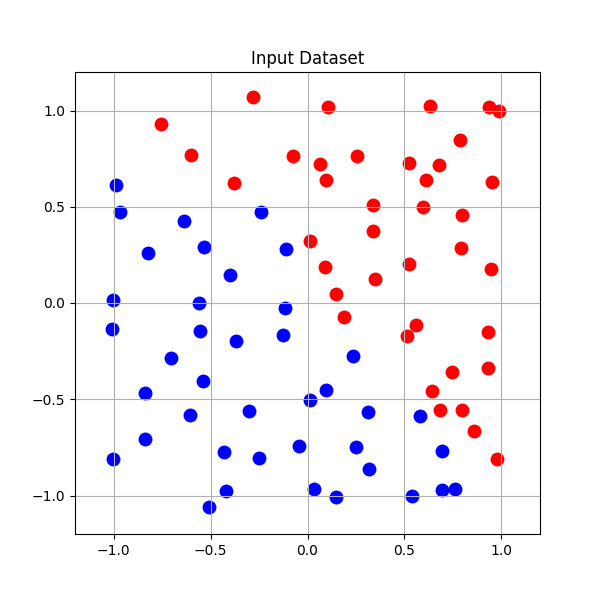

In [3]:
%matplotlib notebook

fig = pl.figure(figsize=(6,6))
pl.title("Input Dataset")
pl.xlim((-1.2,1.2))
pl.ylim((-1.2,1.2))

dataset = []

def onclick(event):
    global dataset
    cx = event.xdata
    cy = event.ydata
    co = event.button
    dataset.append((cx, cy, co-2))

    pl.scatter(cx, cy, c=(['b', 'r'])[co > 2], s=100, lw=0)
    pl.grid(True)


cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [4]:
fig.canvas.mpl_disconnect(onclick)

In [5]:
dataset

[(0.14661290322580656, -1.0073051948051948, -1),
 (0.033064516129032384, -0.9657467532467531, -1),
 (-0.04435483870967727, -0.7423701298701297, -1),
 (0.012419354838709928, -0.5034090909090907, -1),
 (-0.1114516129032257, 0.28100649350649376, -1),
 (-0.2404838709677417, 0.47321428571428603, -1),
 (-0.9888709677419353, 0.6134740259740261, -1),
 (-0.9682258064516127, 0.47321428571428603, -1),
 (-0.8237096774193546, 0.260227272727273, -1),
 (-0.7049999999999998, -0.28522727272727266, -1),
 (-0.8391935483870966, -0.4670454545454543, -1),
 (-0.8391935483870966, -0.7060064935064934, -1),
 (-0.4211290322580643, -0.9761363636363635, -1),
 (-0.25080645161290316, -0.8047077922077921, -1),
 (-0.3024193548387095, -0.5605519480519479, -1),
 (-0.36951612903225795, -0.19691558441558432, -1),
 (-0.40048387096774185, 0.14594155844155865, -1),
 (-0.5346774193548385, 0.29139610389610415, -1),
 (-0.6379032258064514, 0.42646103896103904, -1),
 (-1.0043548387096772, 0.016071428571428736, -1),
 (-1.009516129

## Finding the weights by hand
In this section you should try to find the set of weights that allows a Perceptron to separate the two classes you previously defined. Use the sliders to modify the value of each one of the connections and the bias of the Perceptron while trying to separate the two classes (blue and red). The curve on the right represents the classification error (MSE). If the modifications you provide improve the classification, you should see the error to decrease.

In [6]:
plotter = pt.PerceptronPlotter2D(data=np.asarray(dataset))

In [7]:
%matplotlib inline
_= interact(plotter.plot_interactive, **plotter.controls)

interactive(children=(FloatSlider(value=0.5, description='Weight x:', max=2.0, min=-2.0, step=0.01), FloatSlider(value=0.5, description='Weight y:', max=2.0, min=-2.0, step=0.01), FloatSlider(value=0.0, description='Bias:', max=2.0, min=-2.0, step=0.01), Dropdown(description='Activation function:', index=1, options={'Gaussian': 0, 'Linear': 1, 'Sigmoid': 2, 'Hyperbolic tangent': 3}, value=1), Output()), _dom_classes=('widget-interact',))

## The Delta Rule
In the following step we propose to solve the classification problem you defined by using the delta-rule algorithm. Look at the code in compute_delta_w and try to understand it.

$$ neta = (x * w\_x) + (y * w\_y) + b$$
$$ output = f\_act(neta) $$
$$ \Delta w\_x = \alpha * (target - output) * f\_act'(neta) * x $$
$$ \Delta w\_y = \alpha * (target - output) * f\_act'(neta) * y $$
$$ \Delta b = \alpha * (target - output) * f\_act'(neta) $$

In [8]:
def compute_delta_w(inputs, weights, bias, targets, alpha, activation_function):
    neta = np.dot(inputs, weights) + bias
    output, d_output = activation_function(neta)
    error = targets - output
    d_w_x = alpha * error * d_output * inputs[:,0]
    d_w_y = alpha * error * d_output * inputs[:,1]
    d_b = alpha * error * d_output
    return [d_w_x, d_w_y, d_b]

## Batch learning
When you launch the cell, the weights and the bias are initialized at random, and the algorithm perform some iterations (NUMBER_OF_EPOCHS) doing the following:
+  for each point in the dataset, compute the modifications ( Δw ) to be done at each parameter in order to minimize the error function
+ sum up all the modifications -> batch policy
+ modify the weights and bias of the perceptron

The cell records the effects of the modifications performed in a video. Therefore, you can visualize the learning process afterwards.

In [9]:
%matplotlib inline

inputs = np.asarray(dataset)[:,0:2]
targets = np.asarray(dataset)[:,2]
weights = np.random.normal(size=2)
bias = np.random.normal(size=1)
activation_function = pt.htan

ALPHA = 0.1
NUMBER_OF_EPOCHS = 30

fig = pl.figure(figsize=(8, 4))
plotter = pt.PerceptronPlotter2D(data=np.asarray(dataset))
plotter.init_animation()

def run_epoch_batch(i, alpha, inputs, weights, bias, targets, activation_function):
    d_w_x, d_w_y, d_b = compute_delta_w(inputs, weights, bias, targets, ALPHA, activation_function)
    weights += np.array([np.sum(d_w_x), np.sum(d_w_y)])
    bias += np.sum(d_b)
    
    return plotter.data2animation(i, inputs, weights, bias, targets, activation_function)

SHOW_VIDEO = True       # change this flag if you are unable to see the video
if SHOW_VIDEO:
    anim = animation.FuncAnimation(fig, run_epoch_batch, fargs=(ALPHA, inputs, weights, bias, targets, activation_function), frames=NUMBER_OF_EPOCHS, interval=20, blit=True)
    pt.display_animation(anim)
else:
    for i in np.arange(NUMBER_OF_EPOCHS):
        run_epoch_batch(i, ALPHA, inputs, weights, bias, targets, activation_function)

/home/hector/Desktop/work/mlg-bachelor/labo/mlg-bachelor/local/lib/python3.4/site-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


## Exercise
You are free to modify the learning rate (ALPHA) and the number of iterations (NUMBER_OF_EPOCHS).

Try different 2D classification problems and observe the behaviour of the algorithm in terms of:
- Learning rate needed
- Convergence speed
- Oscillations

Bare in mind that, in the current implementation, the parameters (weights and bias) are initialized randomly every time you launch the cell.

Create some datasets as it is shown, and perform the following tests:

1. What happens if the boundaries between both classes are well defined?
![separable](separable.png)

2. What happens if the classes overlap? What could you say about oscillations in the error signal?
![overlapping](overlapping.png)

3. What happens if it is not possible to separate the classes with a single line? What could you say about local minima?
![non_separable](non_separable.png)
